# Direct Forecasting with `Python` and `R` in `forecastML`
### *Nick Redell* nickalusredell@gmail.com
### 2020-05-13

***

# Purpose

* The goal of this notebook is to show an end-to-end example workflow for forecasting with both `Python` and `R` in `forecastML`. Along the way, we'll compare the results side-by-side and even ensemble the final `Python` and `R` ML models to produce a single multi-step-ahead forecast.
  
  
* The emphasis will be on training models in parallel. Parallel training may be faster or slower depending on the dataset size and ML models used.
  
  
* This notebook is long because it details a mostly complete workflow for ML forecast model exploration. It's a good template. The aim of `forecastML` has been and will be flexibility so this pipeline doesn't have to be followed in detail. There's a fair amount of customization allowed that could have made this notebook much shorter or much longer.

***

# Example: `scikit-learn` in `Python` and `R`

## Task

* **Domain:** Electricity demand in Victoria, Australia
* **Number of time series:** 1
* **Frequency of data collection:** 30 minutes
* **Forecast horizon:** 3-days-ahead
* **Method:** Direct forecasting at 3 time horizons--1 day, 2 days, and 3 days ahead
* **Model outcome:** Demand
* **Model features:** Demand, temperature, holidays, date/time features
* **Models:**
    + `Python`: LASSO from `sklearn`
    + `R`: Random Forest
    + Ensemble of `Python` and `R` models

## Final Product
  
  
<div>
<img src="electricity_demand_final_plot.png"/>
</div>

***

## `R` Setup

In [49]:
options(warn = -1)
options(repr.plot.width = 12, repr.plot.height = 6)

library(reticulate)  # For working with Python.
library(tsibbledata)  # Source of the dataset.
library(lubridate)
library(ggplot2)
library(forecastML)  # v0.9.1
library(ranger)  # Random Forest model in R.
library(future)  # Parallel model training.

***

## Data Preparation in `forecastML`

* Load the example data.

In [2]:
data("vic_elec", package = "tsibbledata")
data <- as.data.frame(vic_elec)

head(data)

,Time,Demand,Temperature,Date,Holiday
,<dttm>,<dbl>,<dbl>,<date>,<lgl>
1,2012-01-01 00:00:00,4263.366,21.05,2012-01-01,TRUE
2,2012-01-01 00:30:00,4048.966,20.70,2012-01-01,TRUE
3,2012-01-01 01:00:00,3877.563,20.55,2012-01-01,TRUE
4,2012-01-01 01:30:00,4036.230,20.40,2012-01-01,TRUE
5,2012-01-01 02:00:00,3865.597,20.25,2012-01-01,TRUE
6,2012-01-01 02:30:00,3694.098,20.10,2012-01-01,TRUE


### Date and time info

In [3]:
frequency <- "30 min"  # A string that works in base::seq(..., by = 'frequency').

records_per_day <- 48  # 48 30-minute periods in a day for easier indexing.

data$Time <- as.POSIXct(data$Time, tz = "UTC")  # Our date index.

### `forecastML::fill_gaps()`

* There are no gaps in data collection in this dataset. If there were, `fill_gaps()` would expand the dataset and auto-fill our date index which is `Time` here. This function also supports multiple time series.

<p>

* The purpose of `fill_gaps()` is to prepare a dataset to produce temporally correct feature lags. You can use any package or method to fill in `NA` values--or leave them missing if your ML model handles them--so long as the filled-in dataset is a `data.frame`.

In [4]:
data <- forecastML::fill_gaps(data, date_col = 1, frequency = frequency)

### Date-based feature engineering

In [5]:
data$hour <- lubridate::hour(data$Time)
data$weekday <- factor(lubridate::wday(data$Time))  # Factor for modeling purposes.
data$month <- factor(lubridate::month(data$Time))  # Factor for modeling purposes.
data$year <- lubridate::year(data$Time)

head(data)

,Time,Demand,Temperature,Date,Holiday,hour,weekday,month,year
,<dttm>,<dbl>,<dbl>,<date>,<lgl>,<int>,<fct>,<fct>,<dbl>
1,2012-01-01 00:00:00,4263.366,21.05,2012-01-01,TRUE,0,1,1,2012
2,2012-01-01 00:30:00,4048.966,20.70,2012-01-01,TRUE,0,1,1,2012
3,2012-01-01 01:00:00,3877.563,20.55,2012-01-01,TRUE,1,1,1,2012
4,2012-01-01 01:30:00,4036.230,20.40,2012-01-01,TRUE,1,1,1,2012
5,2012-01-01 02:00:00,3865.597,20.25,2012-01-01,TRUE,2,1,1,2012
6,2012-01-01 02:30:00,3694.098,20.10,2012-01-01,TRUE,2,1,1,2012


### Train/Test split

* **Train:** From **2012-01-01 00:00:00** to **2014-12-28 23:30:00**
* **Test:**  From **2012-12-29 00:00:00** to **2014-12-31 23:30:00**
* **Forecast:**  From **2015-01-01 00:00:00** to **2015-01-03 23:30:00**

In [6]:
train_indices <- 1:(nrow(data) - records_per_day * 3)  # The test dataset will be the final 3 days of the dataset.

train <- data[train_indices, ]
test <- data[-train_indices, ]

### Plot time series

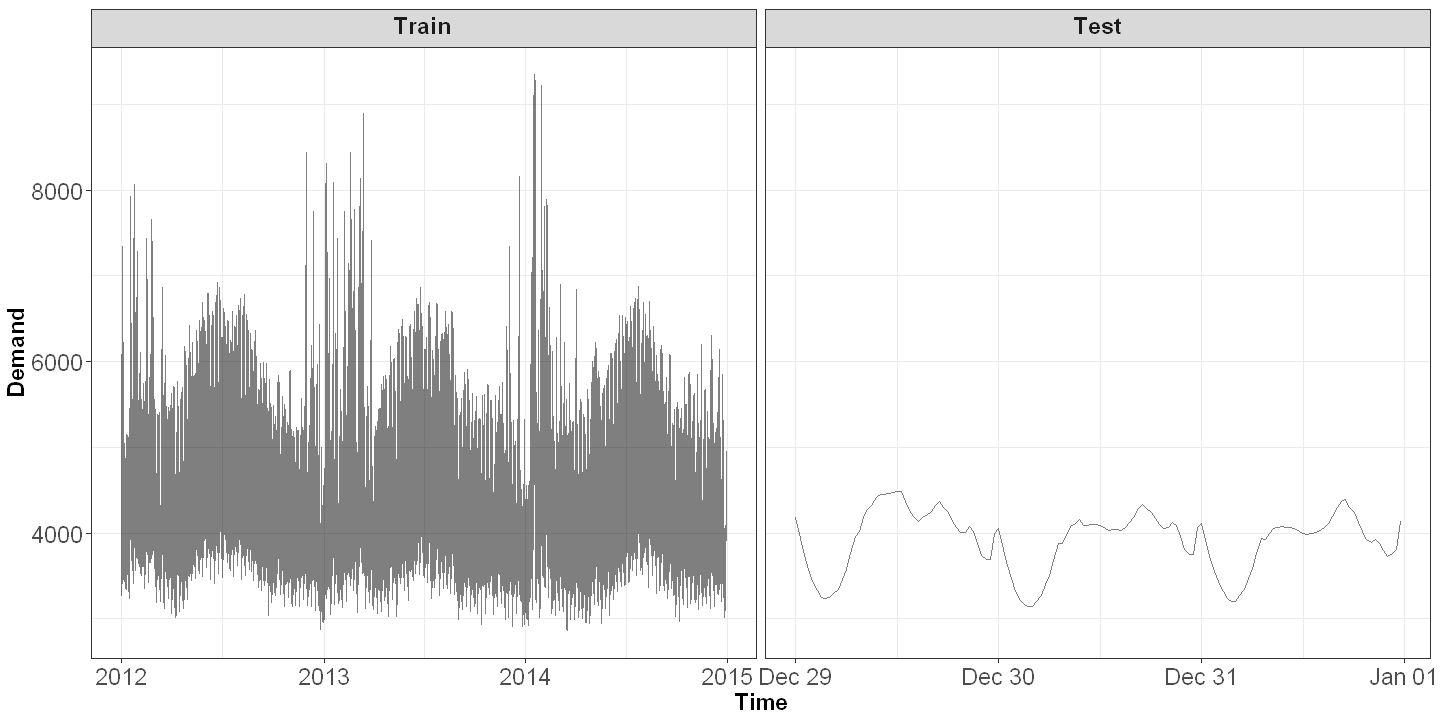

In [7]:
data$dataset <- "Test"
data$dataset[train_indices] <- "Train"
data$dataset <- factor(data$dataset, levels = c("Train", "Test"), ordered = TRUE)

p <- ggplot(data, aes(Time, Demand))
p <- p + geom_line(alpha = .5)
p <- p + facet_wrap(~ dataset, scales = "free_x")
p <- p + theme_bw() + theme(
    strip.text = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 14, face = "bold"),
    axis.text = element_text(size = 14)
    )
p

### `forecastML::create_lagged_df(type = "train")`

* The outcome--`Demand`--and non-dynamic features--`Temperature`--will be lagged to produce additional model features.


In [8]:
outcome_col <- 1  # The column position of our 'Demand' outcome (after removing the date columns).

# Forecast 1, 1:2, and 1:3 days into the future in 30-second increments; horizons: c(48, 96, 144).
horizons <- c(records_per_day, records_per_day * 2, records_per_day * 3)

# Feature lags in 30 minute intervals: c(48, 60, 72, 84, 96, 108, 120, 132, 144, 336, 17520).
# These will be the same across the 3 horizon-specific models and lagged features but can easily be customized.
# Notice that feature lags that do not support direct forecasting at a given horizon are silently dropped.
lookback <- c(seq(48, records_per_day * 3, 12), records_per_day * 7, records_per_day * 365)

dates <- train$Time  # Data were collected every 30 minutes.

# We don't need or want dates/times in the modeling dataset.
train$Time <- NULL
train$Date <- NULL

# Features that change through time but which will not be lagged.
dynamic_features <- c("Holiday", "hour", "weekday", "month", "year")

data_train <- forecastML::create_lagged_df(train, type = "train", outcome_col = outcome_col,
                                           lookback = lookback, horizon = horizons,
                                           dates = dates, frequency = frequency,
                                           dynamic_features = dynamic_features
                                           )

head(data_train$horizon_48)  # View the horizon-48 dataset.

,Demand,Demand_lag_48,Demand_lag_60,Demand_lag_72,Demand_lag_84,Demand_lag_96,Demand_lag_108,Demand_lag_120,Demand_lag_132,Demand_lag_144,...,Temperature_lag_120,Temperature_lag_132,Temperature_lag_144,Temperature_lag_336,Temperature_lag_17520,Holiday,hour,weekday,month,year
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<int>,<fct>,<fct>,<dbl>
17521,3793.408,3798.725,4024.087,3773.823,3153.369,3860.470,4242.562,4179.424,3457.442,3884.273,...,19.4,15.8,17.5,28.3,21.05,FALSE,0,2,12,2012
17522,3539.669,3553.194,3976.957,3736.326,3286.841,3598.926,4130.221,4140.792,3611.500,3603.680,...,19.7,16.3,17.4,28.3,20.70,FALSE,0,2,12,2012
17523,3331.797,3350.125,3911.977,3726.622,3416.320,3396.722,4047.653,4132.465,3803.363,3430.441,...,20.6,16.2,17.4,28.1,20.55,FALSE,1,2,12,2012
17524,3399.011,3411.350,3869.712,3706.496,3463.026,3442.153,3986.940,4097.013,3847.211,3504.365,...,20.0,16.6,17.4,29.0,20.40,FALSE,1,2,12,2012
17525,3336.056,3334.223,3903.324,3690.539,3571.581,3370.289,4001.785,4067.422,3982.959,3405.804,...,21.2,16.9,17.3,29.4,20.25,FALSE,2,2,12,2012
17526,3204.986,3193.918,3963.970,3696.588,3693.446,3231.974,4036.003,4069.680,4105.008,3274.821,...,20.9,16.1,16.4,29.1,20.10,FALSE,2,2,12,2012


### Optional - External validation datasets with `forecastML::create_windows()`

* The "optional" part is that you could set `create_windows(window_length = 0)` and train a model over all of the training data and not worry about assessing historical forecast performance; this--no external CV--is how the final model is trained.
  
  
* We'll measure our models' generalization performance on 1 validation window. This window is a similar time of the year as our test dataset--December--but 1 year in the past.
  
  
* You can have multiple validation windows; though, 1 model will be trained for each contiguous validation window so the challenge will be in choosing the optimal hyperparameters for the final model...or use a bunch of models trained on different data or differentially weighted data. The choice is yours.
  
  
* Notice how the first year of data is missing in the plot below. This is because our longest feature lookback was 1 year in the past which would have introduced missing data for these features at any time in 2012 (if the dataset rows were retained). These rows can be kept with `create_lagged_df(keep_rows = TRUE)`.

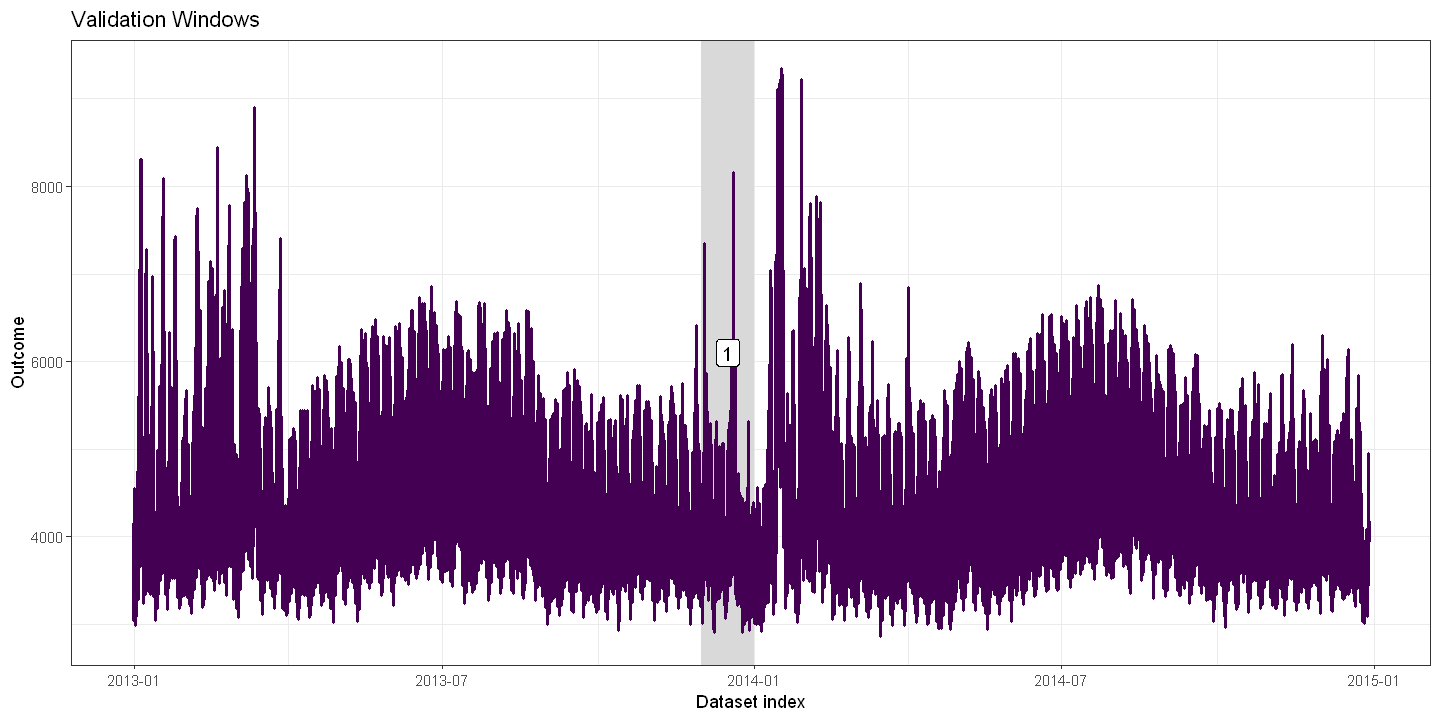

In [9]:
windows <- forecastML::create_windows(data_train,
                                      window_length = 0,  # Zero auto-spans from window_start to window_stop.
                                      window_start = as.POSIXct("2013-12-01", tz = "UTC"),
                                      window_stop = as.POSIXct("2014-01-01", tz = "UTC"))

plot(windows, data_train)

***

## Modeling in `forecastML`

* **`Python` workflow**:
    1. Read a .py script with `reticulate` in `R` to import `Python` libraries, classes, and functions. For non-parallel training, a `Python` code block in `R` Markdown works.
    2. Write an `R` wrapper. For non-parallel training, this is optional. The purpose of the `R` wrapper is to save a pickeled trained `Python` model to disk because the pointers that `R` uses to find the correct `Python` object are ephemeral and the models will be lost when training in parallel.
    3. Load the saved pickeled model into `R` with `reticulate` and attach it as an attribute in the "model" slot of a `forecastML` trained model object.

### `Python` model function
#### `Python` model function in `model_script.py`

* The two cells below are plain text but illustrate the function used in `model_script.py` which is in the same directory as this notebook.

#### `R` wrapper for `Python` model function in `model_script.py`

In [10]:
r_wrapper_for_py_model_fun <- function(data) {  # A horizon-specific pd.DataFrame from forecastML::create_lagged_df().
  
  reticulate::source_python("model_script.py")
  
  py_model_return <- reticulate::py$py_model_fun(data)  # $py brings the Python function into R.
  
  horizon <- py_model_return$horizon  # This is our dict key 'horizon' in the cell above.
  
  # A uniquely named Python model object with meta-data being saved to disk for parallel training.
  reticulate::py_save_object(py_model_return, paste0("py_model_horizon_", horizon, ".pkl"), pickle = "pickle")
}

### `R` model function

In [11]:
r_model_fun <- function(data) {

  outcome_names <- names(data)[1]
  model_formula <- formula(paste0(outcome_names,  "~ ."))

  model <- ranger::ranger(model_formula, data = data, num.trees = 300)
  return(model)
}

### `forecastML::train_model()`

#### `Python` - Model training with internal and external CV

In [12]:
future::plan(future::multiprocess)  # Mutli-core on Linux; multi-R-session on Windows.

model_results_py <- forecastML::train_model(data_train,
                                            windows = windows,
                                            model_name = "Python LASSO",  # Can be any name.
                                            model_function = r_wrapper_for_py_model_fun,
                                            use_future = TRUE,  # Parallel training.
                                            python = TRUE
                                            )

* This is step 3 from the `Python` workflow mentioned earlier. At present, this is a bit manual due to obstacles when using `reticulate` in parallel.
  
  
* The `Python` model is now where it needs. If you trained with multiple validation windows, you'd need a nested loop to assign each model to the correct combination of horizon and window.

In [13]:
for (i in seq_along(horizons)) {
  
  model_name <- paste0("py_model_horizon_", horizons[i])  # Horizons 48, 96, and 144.
  
  model_results_py[[i]]$window_1$model <- reticulate::py_load_object(paste0(model_name, ".pkl"), pickle = "pickle")
}

model_results_py[[i]]$window_1$model

$model
LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

$scaler
StandardScaler(copy=True, with_mean=True, with_std=True)

$horizon
[1] 144


#### `R` - Model training with internal and external CV

* There's actually no internal CV in our `R` model function; the hyperparamters are fixed to speed up the runtime.

In [14]:
future::plan(future::multiprocess)  # Mutli-core on Linux; multi-R-session on Windows.

model_results_r <- forecastML::train_model(data_train,
                                           windows = windows,
                                           model_name = "R Random Forest",  # Can be any name.
                                           model_function = r_model_fun,
                                           use_future = TRUE  # Parallel training.
                                           )

***

## Historical Prediction in Validation Window(s)

### `Python` predict function

#### `Python` predict function in `model_script.py`

* The cell below is plain text but illustrates the function used in `model_script.py`.

#### `R` wrapper for `Python` predict function in `model_script.py`

In [15]:
r_wrapper_for_py_predict_fun <- function(model_list, data) {
  
  reticulate::source_python("model_script.py")
  
  reticulate::py$py_predict_fun(model_list, data)  # $py brings the Python function into R.
}

### `R` predict function

In [16]:
r_predict_fun <- function(model, data) {

  data_pred <- data.frame("y_pred" = predict(model, data)$predictions)
  return(data_pred)
}

### `forecastML::predict()`

* These predictions are for our 1 validation dataset in December 2013.

In [17]:
data_valid <- predict(model_results_py, model_results_r,
                      prediction_function = list(r_wrapper_for_py_predict_fun, r_predict_fun),
                      data = data_train)

### Plot historical predictions in the validation window

* **1st plot:** All ML models, all direct horizons, all 30-minute periods in the validation window.
  
  
* **2nd plot:** 1st plot filtered to focus on December 31st.
  
  
* **3rd plot:** 2nd plot, faceted to plot overlapped models, custom colors.

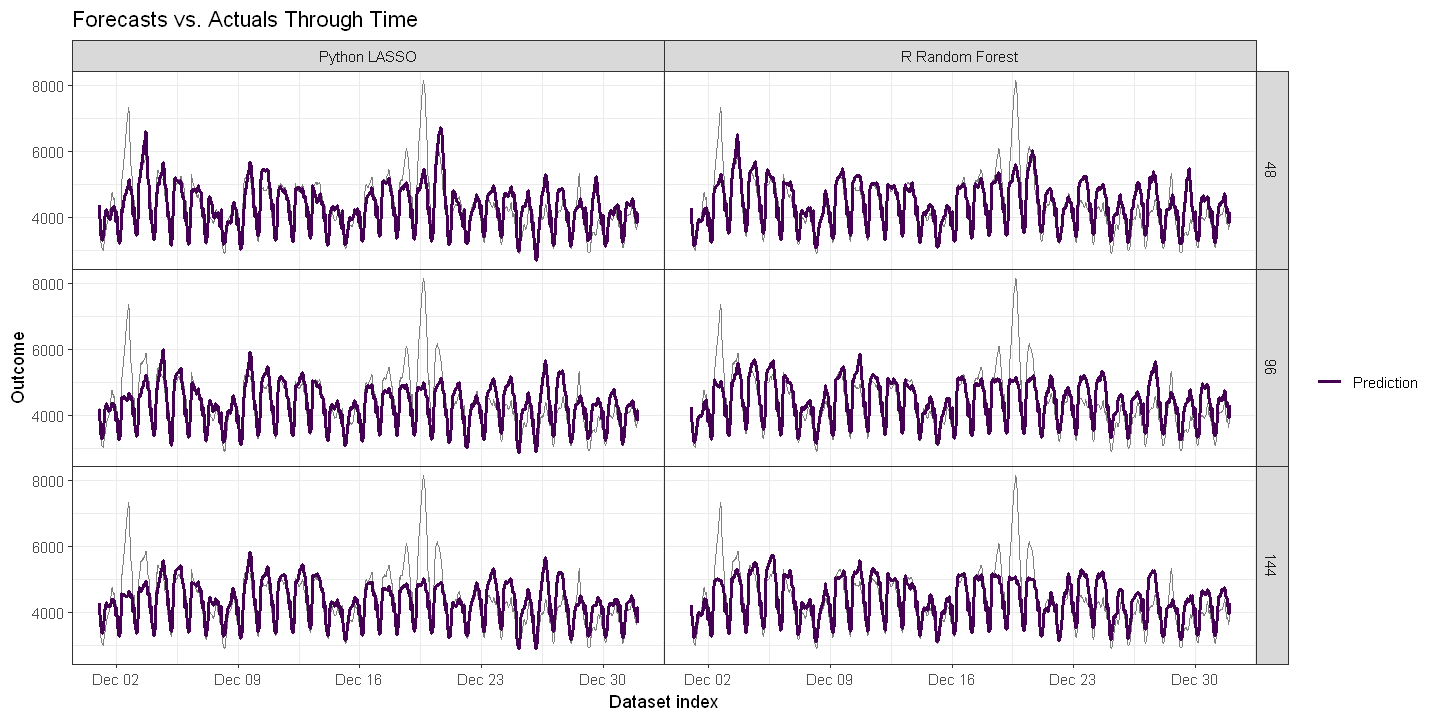

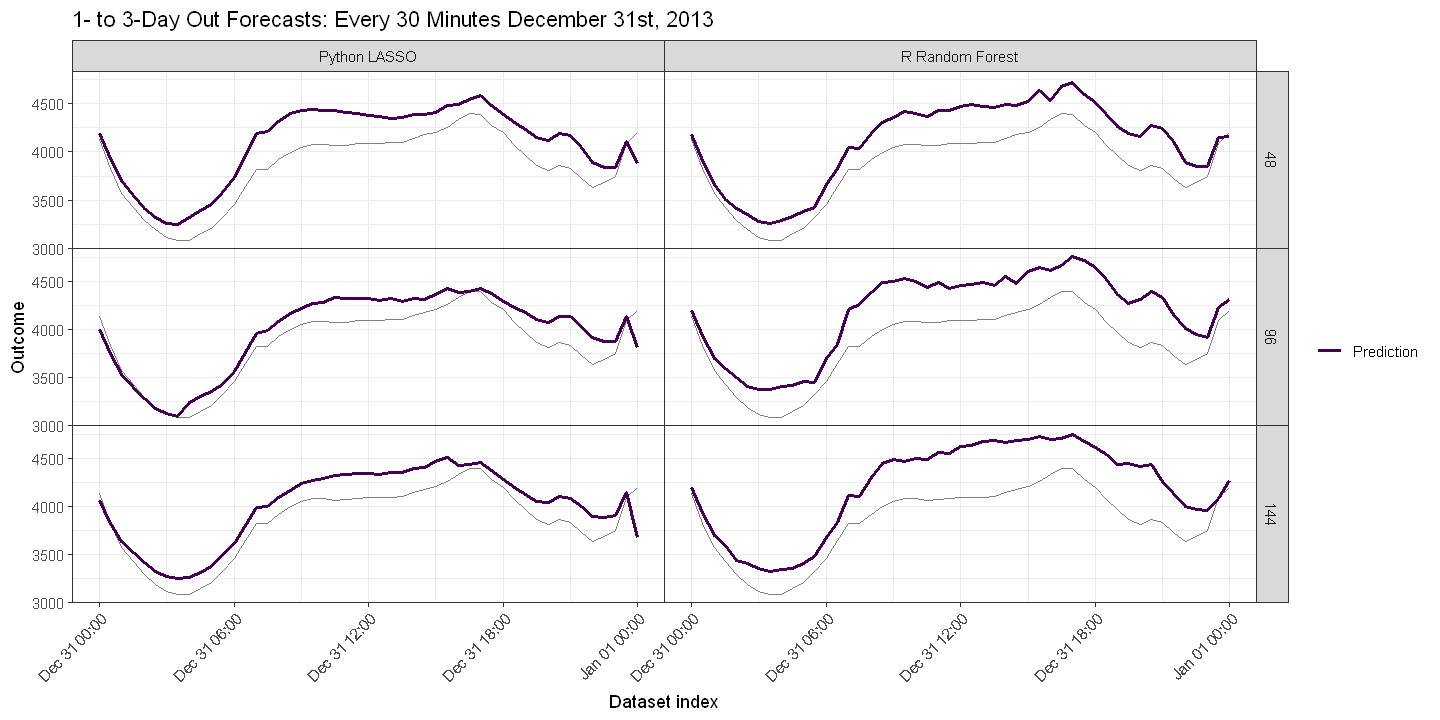

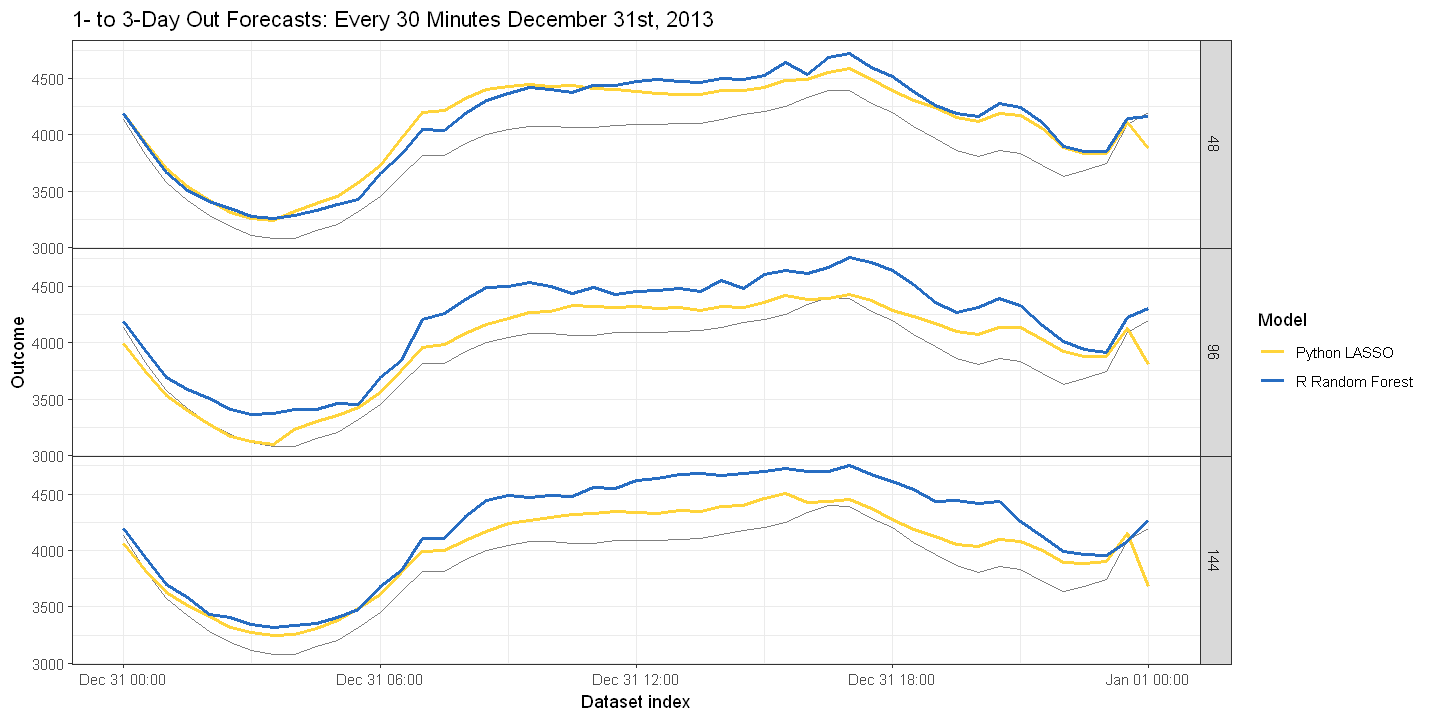

In [18]:
plot(data_valid)

view_dates <- seq(as.POSIXct("2013-12-31", tz = "UTC"), 
                  as.POSIXct("2014-01-01", tz = "UTC"), 
                  by = "30 min")

plot(data_valid, valid_indices = view_dates) + theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  ggtitle("1- to 3-Day Out Forecasts: Every 30 Minutes December 31st, 2013")

plot(data_valid, facet = horizon ~ ., valid_indices = view_dates) + 
  ggtitle("1- to 3-Day Out Forecasts: Every 30 Minutes December 31st, 2013") + 
  scale_color_manual(values = c("Python LASSO" = "#ffd43b", "R Random Forest" = "#276DC2"))

***

## Historical Error in Validation Window(s)

### `forecastML::return_error()`

In [19]:
data_error <- forecastML::return_error(data_valid)

#### `forecastML::plot()` error by direct forecast horizon

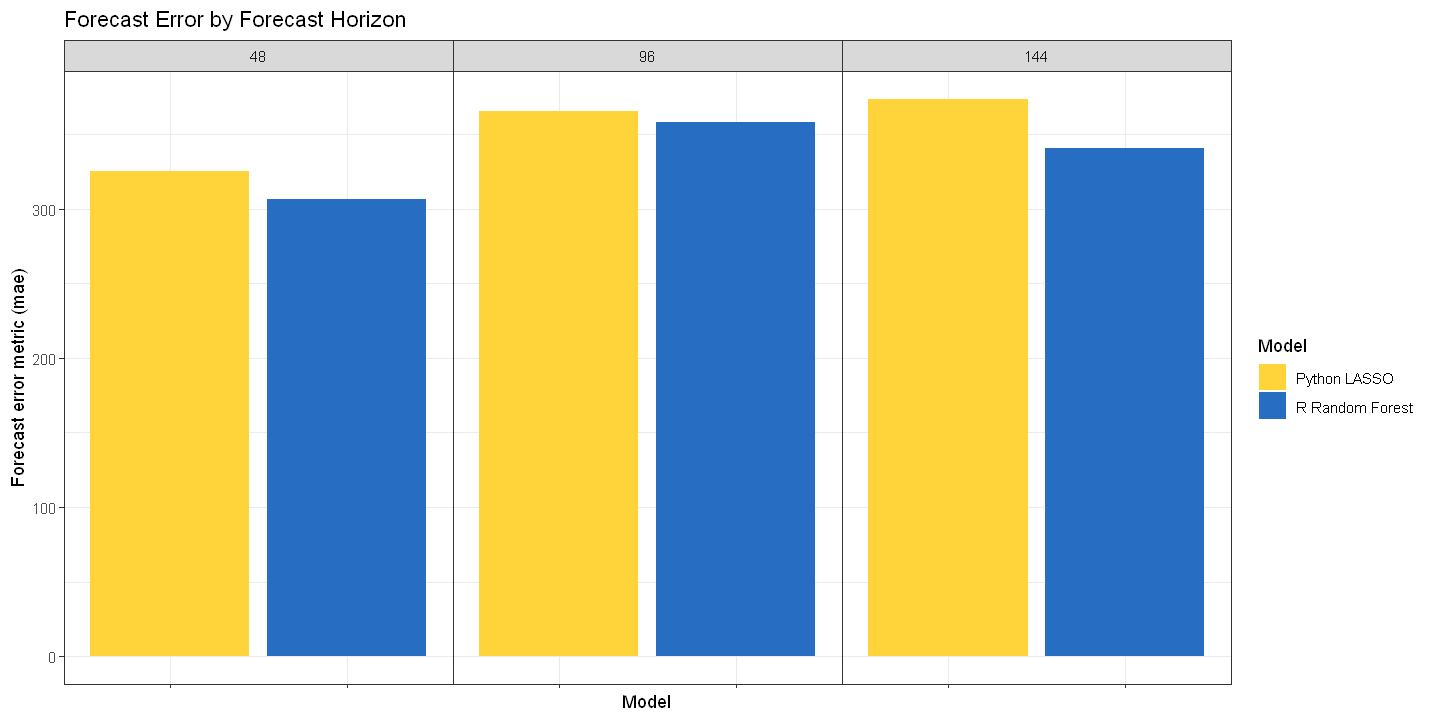

In [20]:
plot(data_error, type = "horizon", facet = ~ horizon) + 
  scale_fill_manual(values = c("Python LASSO" = "#ffd43b", "R Random Forest" = "#276DC2"))

#### `forecastML::plot()` error collapsed across direct forecast horizons

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



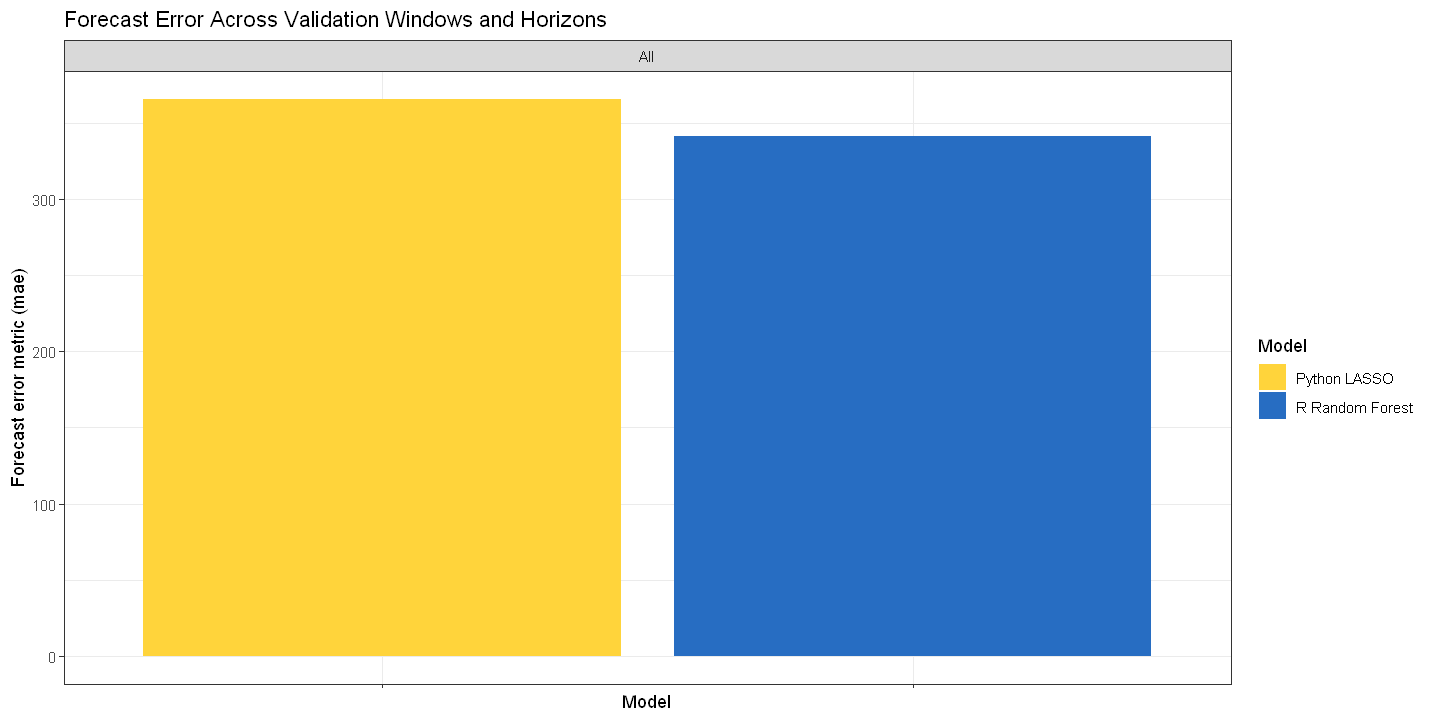

In [21]:
plot(data_error, type = "global", facet = ~ horizon) + 
  scale_fill_manual(values = c("Python LASSO" = "#ffd43b", "R Random Forest" = "#276DC2"))

***
## Forecast in `forecastML`

### `forecastML::create_lagged_df(type = "forecast")`

In [22]:
data_forecast <- forecastML::create_lagged_df(train, type = "forecast", outcome_col = 1,
                                              lookback = lookback, horizon = horizons,
                                              dates = dates, frequency = frequency,
                                              dynamic_features = dynamic_features)

head(data_forecast$horizon_144)  # View the horizon-144 dataset.

,index,horizon,Demand_lag_144,Demand_lag_336,Demand_lag_17520,Temperature_lag_144,Temperature_lag_336,Temperature_lag_17520,Holiday,hour,weekday,month,year
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,2014-12-29 00:00:00,1,3907.916,4349.082,3997.274,11.9,20.0,15.9,NA,NA,NA,NA,NA
2,2014-12-29 00:30:00,2,3708.430,4088.169,3698.171,13.0,19.4,16.1,NA,NA,NA,NA,NA
3,2014-12-29 01:00:00,3,3571.791,3878.761,3426.123,13.4,19.0,16.0,NA,NA,NA,NA,NA
4,2014-12-29 01:30:00,4,3427.215,3729.914,3295.835,13.5,19.0,15.6,NA,NA,NA,NA,NA
5,2014-12-29 02:00:00,5,3288.186,3592.806,3166.052,13.3,18.9,15.4,NA,NA,NA,NA,NA
6,2014-12-29 02:30:00,6,3151.568,3493.213,3071.107,12.9,18.8,15.4,NA,NA,NA,NA,NA


### Fill in future dynamic features

* Filling in future `NA` values for non-lagged features is a bit of a manual process.
  
  
* The features can remain `NA` if the ML model can handle missing values.
  
  
* The feature types (e.g., factor) should match the training dataset to work with the trained ML model. Don't add new features here.

In [23]:
# Loop over the 48-, 96, and 144-step-ahead horizon datasets from create_lagged_df().
for (i in seq_along(horizons)) {
  
  data_forecast[[i]]$hour <- lubridate::hour(data_forecast[[i]]$index)
  data_forecast[[i]]$weekday <- factor(lubridate::wday(data_forecast[[i]]$index))
  data_forecast[[i]]$month <- factor(lubridate::month(data_forecast[[i]]$index))
  data_forecast[[i]]$year <- lubridate::year(data_forecast[[i]]$index)
  
  # New Year's Eve; this isn't a production-ready approach.
  data_forecast[[i]]$Holiday <- with(data_forecast[[i]], ifelse(lubridate::mday(data_forecast[[i]]$index) == 31, TRUE, FALSE))
}

### Forecast with `forecastML::predict()`

* Unless a new function is needed, the same `predict()` function used to make historical validation predictions can often be used to produce forecasts.
  
  
* We're going to run `predict()` 3 times to view the forecasts at different levels:
    1. **`Python` only**
    2. **`R` only**
    3. **`Python` and `R` together** which will allow is to create a simple ensemble model.

In [24]:
data_forecasts_py <- predict(model_results_py,
                             prediction_function = list(r_wrapper_for_py_predict_fun), 
                             data = data_forecast)

data_forecasts_r <- predict(model_results_r,
                            prediction_function = list(r_predict_fun), 
                            data = data_forecast)

data_forecasts <- predict(model_results_py, model_results_r,
                          prediction_function = list(r_wrapper_for_py_predict_fun, r_predict_fun), 
                          data = data_forecast)

#### `forecastML::plot()` forecasts from the end of the training data

* We've purposefully held out a test dataset that matches our 3-day forecast horizon from the end of the training data. This isn't necessary but is good practice. It's the gray line in the plot below.

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



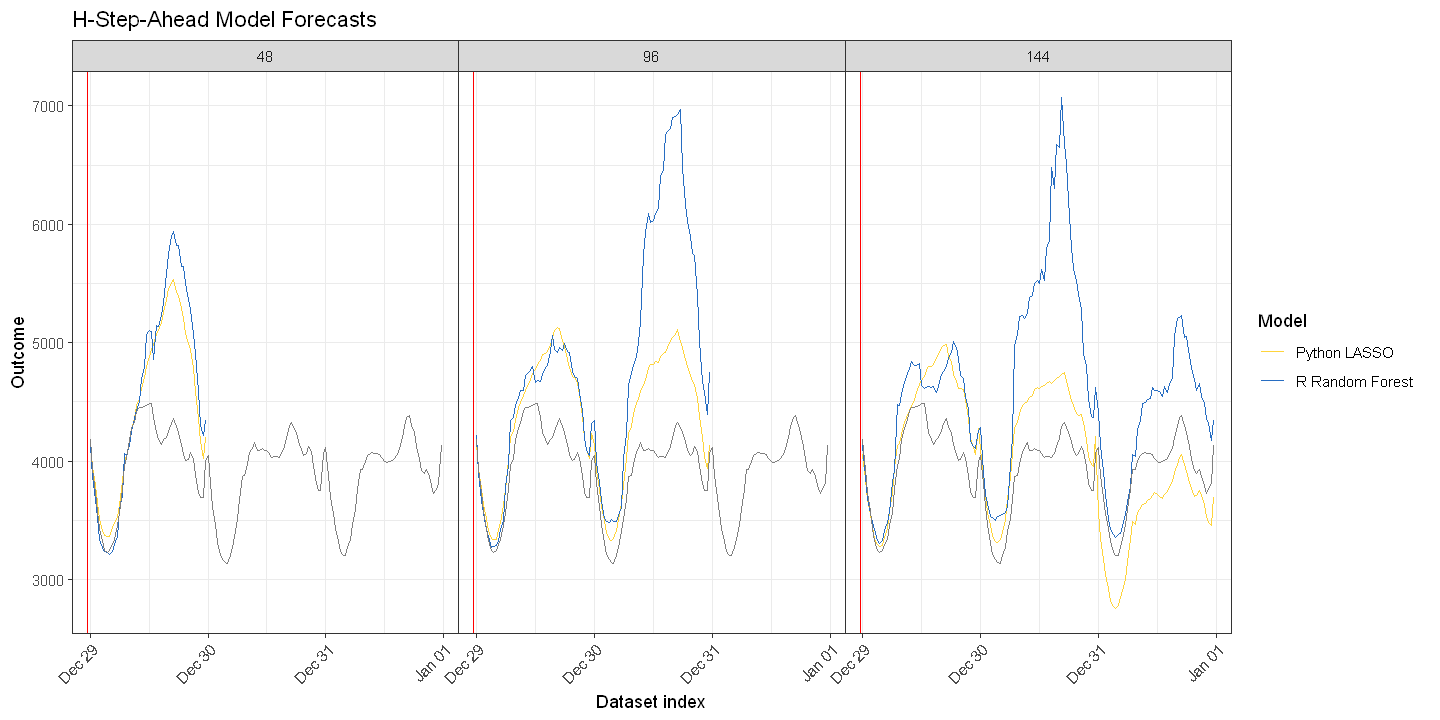

In [25]:
plot(data_forecasts, facet = ~ horizon,
     data_actual = test,
     actual_indices = test$Time) + 
  scale_color_manual(values = c("Python LASSO" = "#ffd43b", "R Random Forest" = "#276DC2")) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

### `forecastML::combine_forecasts()`

* For each of `Python` and `R`, our 3 direct-horizon forecast models have been separately trained and are producing distinct forecasts at various horizons. The first ensemble is to combine the 3 direct-horizon forecasts into a single forecast. The second ensemble--which is optional--is to average different ML models in a cross-sectional way at each forecast step into the future.
  
  
* Below we'll create an ensemble of the `Python` LASSO and the `R` Random Forest models using the strategy outlined at the end of the [forecast combination vignette](https://nredell.github.io/forecastML/doc/combine_forecasts).

In [26]:
data_combined_py <- forecastML::combine_forecasts(data_forecasts_py)

data_combined_r <- forecastML::combine_forecasts(data_forecasts_r)

data_combined <- forecastML::combine_forecasts(data_forecasts, aggregate = stats::median)

#### Custom plot - Individual forecasts on 1 plot

* `forecastML` was written with flexibility in mind. In this context, that means that the built-in plots can often be extended in a straightfoward way using the various function returns in the `forecastML` pipeline. The **black** line below shows the ensemble forecast.

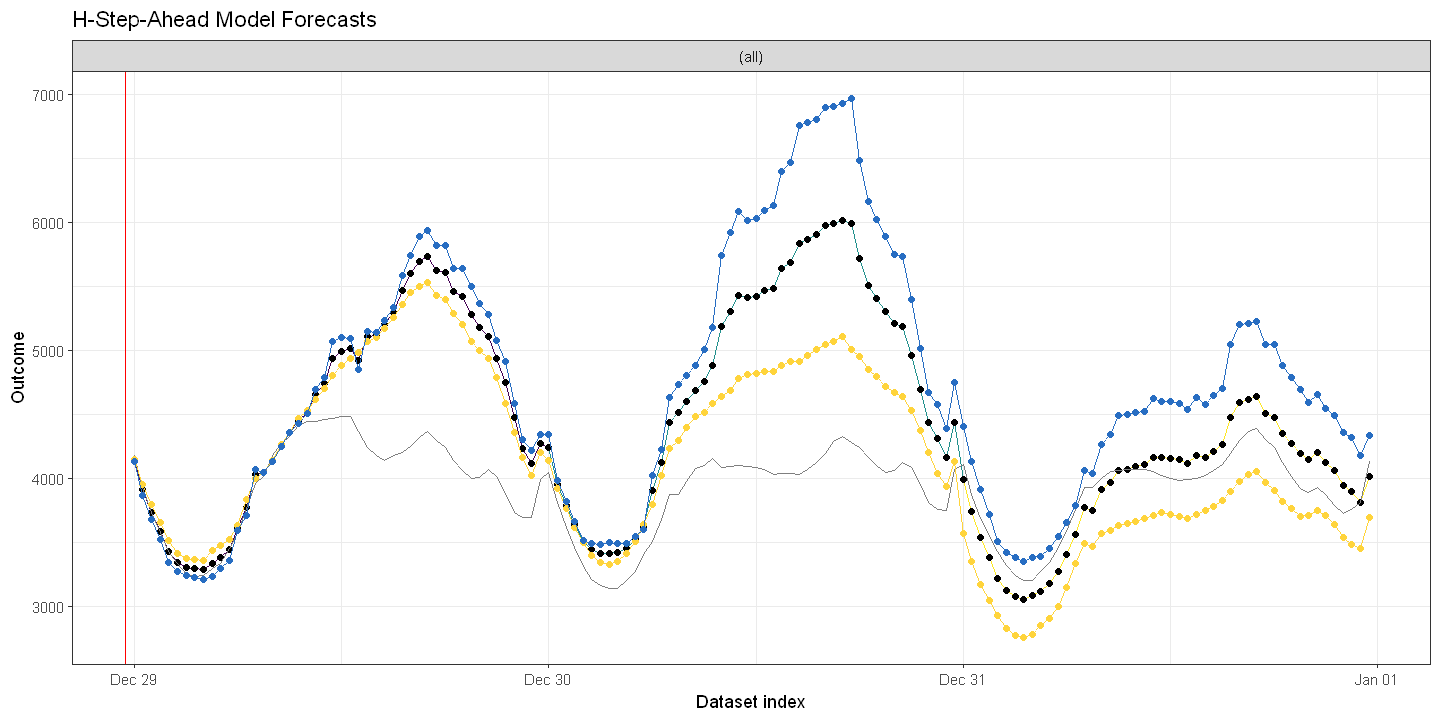

In [27]:
plot(data_combined, data_actual = test, actual_indices = test$Time) + 
  geom_line(data = data_combined_py, aes(x = forecast_period, y = Demand_pred, color = "#ffd43b"), color = "#ffd43b") + 
  geom_point(data = data_combined_py, aes(x = forecast_period, y = Demand_pred, color = "#ffd43b"), color = "#ffd43b") + 
  geom_line(data = data_combined_r, aes(x = forecast_period, y = Demand_pred), color = "#276DC2") + 
  geom_point(data = data_combined_r, aes(x = forecast_period, y = Demand_pred), color = "#276DC2") + 
  facet_wrap(~ NULL) + theme(legend.position = "none")

***

## Forecast error on the test dataset with `forecastML::return_error()`

* Remember that, although we're assessing forecast error below on the test dataset, we still haven't trained on the data in our 1 historical validation window. So this isn't 100% the linear workflow if you were trying to, say, win a Kaggle competition.

In [28]:
data_error_py <- forecastML::return_error(data_combined_py, data_test = test, test_indices = test$Time)

data_error_r <- forecastML::return_error(data_combined_r, data_test = test, test_indices = test$Time)

data_error <- forecastML::return_error(data_combined, data_test = test, test_indices = test$Time)

#### Custom plot - MAE forecast error by forecast horizon

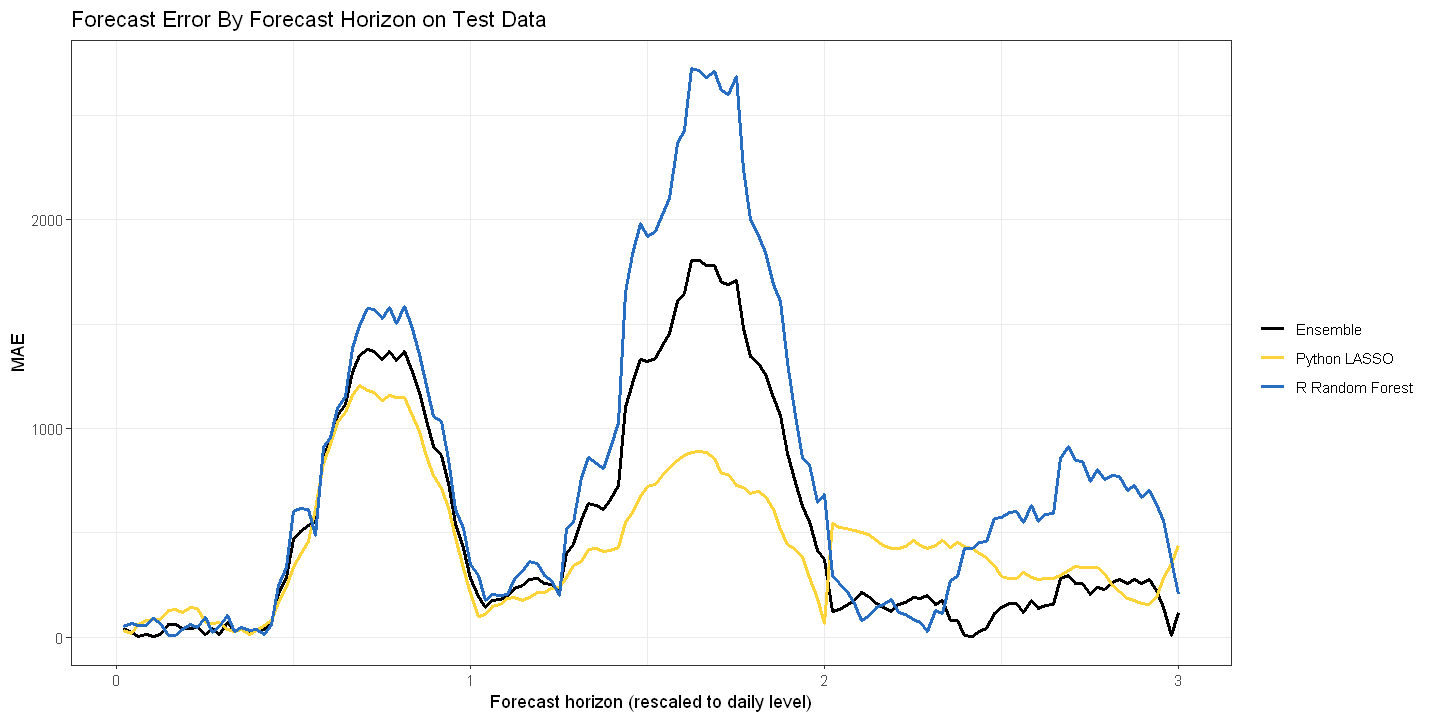

In [29]:
data_plot <- dplyr::bind_rows(data_error_py$error_by_horizon, data_error_r$error_by_horizon, data_error$error_by_horizon)

p <- ggplot(data_plot, aes(horizon / records_per_day, mae, color = model))
p <- p + geom_line(size = 1.05)
p <- p + scale_color_manual(values = c("Python LASSO" = "#ffd43b", "R Random Forest" = "#276DC2", "Ensemble" = "black"))
p <- p + theme_bw()
p <- p + xlab("Forecast horizon (rescaled to daily level)") + ylab("MAE") + labs(color = NULL) + 
  ggtitle("Forecast Error By Forecast Horizon on Test Data")
p

#### Custom plot - MAE forecast error collapsed across horizons

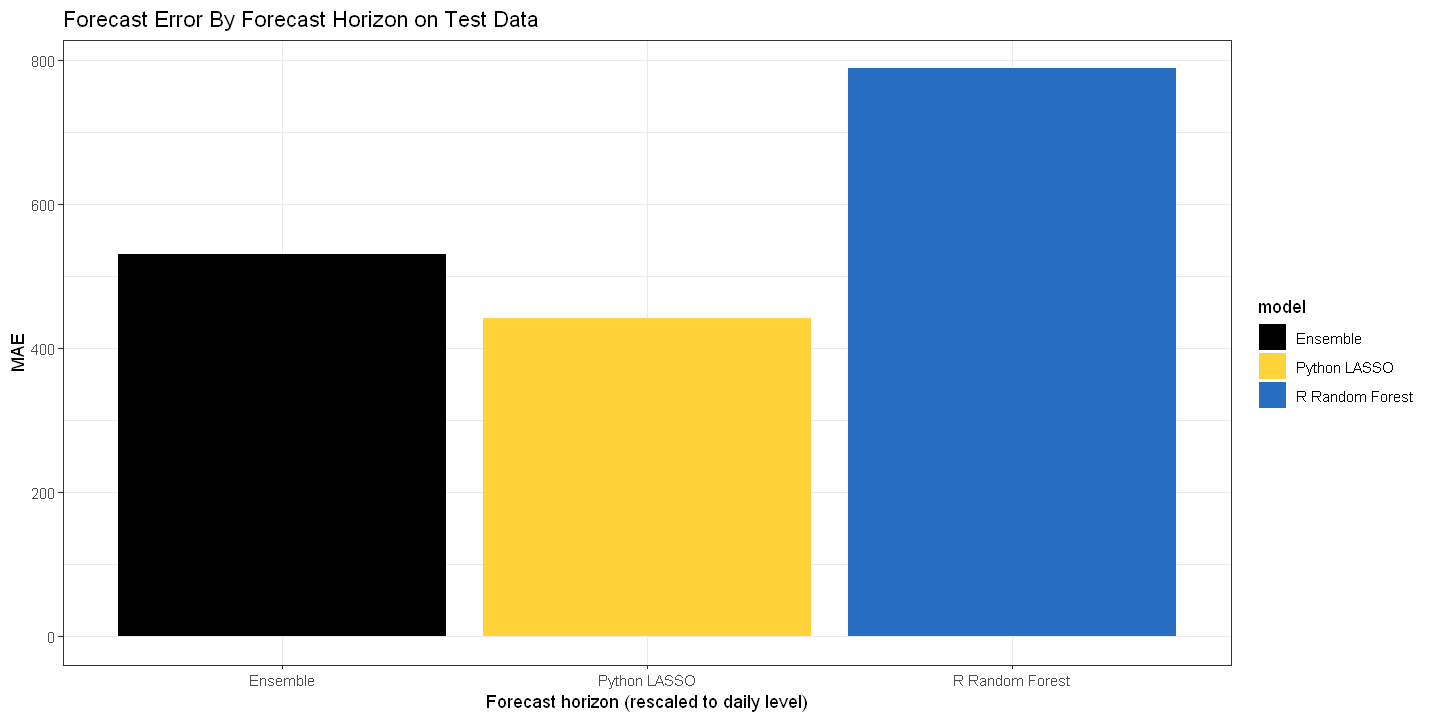

In [30]:
data_plot <- dplyr::bind_rows(data_error_py$error_global, data_error_r$error_global, data_error$error_global)

p <- ggplot(data_plot, aes(model, mae, fill = model))
p <- p + geom_col()
p <- p + scale_fill_manual(values = c("Python LASSO" = "#ffd43b", "R Random Forest" = "#276DC2", "Ensemble" = "black"))
p <- p + theme_bw()
p <- p + xlab("Forecast horizon (rescaled to daily level)") + ylab("MAE") + labs(color = NULL) + 
  ggtitle("Forecast Error By Forecast Horizon on Test Data")
p

***

## Retrain with All Data & Produce Final Forecasts

* Set `create_windows(..., window_length = 0)` to train over all data. Historical predictions will essentially produce fit statistics.

In [31]:
data_all <- dplyr::bind_rows(train, test)

### `forecastML::create_lagged_df(type = "train")`

In [32]:
data_all$Time <- NULL  # Still in the test dataset at this point.
data_all$Date <- NULL  # Still in the test dataset at this point.

dates <- as.POSIXct(data[, "Time", drop = TRUE])  # All dates from train + test.

data_train <- forecastML::create_lagged_df(data_all, type = "train", outcome_col = 1,
                                           lookback = lookback, horizons = horizons,
                                           dates = dates, frequency = frequency,
                                           dynamic_features = dynamic_features)

### `forecastML::create_windows(window_length = 0)`

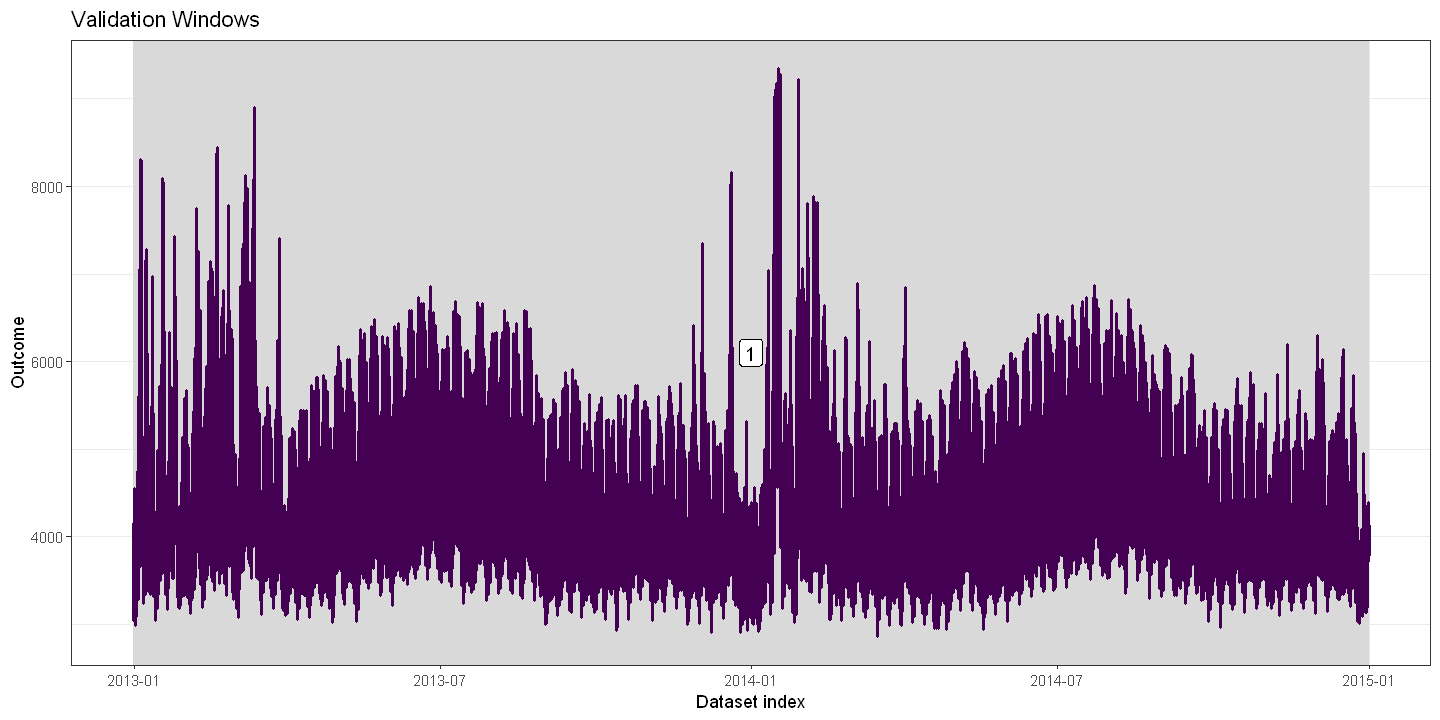

In [33]:
windows <- forecastML::create_windows(data_train, window_length = 0)

plot(windows, data_train)

### `forecastML::train_model()`

### `Python` model functions
#### Fix hyperparameters

* The hyperparameters will be created in `R` and passed into the final `Python` modeling function; however, they could have been created in `Python`.

In [34]:
py_lasso_alphas <- lapply(model_results_py, function(x) {
  x$window_1$model$model$alpha_  # $alpha_ is a model attribute in sklearn.linear_model.LassoCV().fit()
})

# Heads up: reticulate seems to convert numeric R list names (i.e., `48` with backticks) 
# into character dict keys in Python. So we'll be explicit and use and expect characters in Python.
hyperparameters = list("48" = list('alpha' = py_lasso_alphas[[1]]),
                       "96" = list('alpha' = py_lasso_alphas[[2]]),
                       "144" = list('alpha' = py_lasso_alphas[[3]]))

hyperparameters

$`48`
$`48`$alpha
[1] 0.6903668


$`96`
$`96`$alpha
[1] 0.9054891


$`144`
$`144`$alpha
[1] 3.919646

#### `Python` model function in `model_script.py`

* This is the final modeling function with fixed hyperparameters and no cross-validation.
  
  
* **Arguments passed through the `R` wrapper:**
    + **data:** The horizon-specific training dataset from create_lagged_df(type = "train").
    + **hyperparameters:** The optimal `sklearn` LASSO hyperparameters passed from `R`.
    + There are no argument name restrictions in any user-defined function.

#### `R` wrapper for `Python` model function in `model_script.py`

In [35]:
r_wrapper_for_py_model_fun_final <- function(data, hyperparameters) {
  
  reticulate::source_python("model_script.py")
  
  py_model_return <- reticulate::py$py_model_fun_final(data, hyperparameters)
  
  horizon <- py_model_return$horizon
  
  reticulate::py_save_object(py_model_return, paste0("py_model_final_horizon_", horizon, ".pkl"), pickle = "pickle")
}

### `Python` - Model training with no internal or external CV

In [36]:
future::plan(future::multiprocess)

model_results_py_final <- forecastML::train_model(data_train,
                                                  windows = windows,
                                                  model_name = "Python LASSO",
                                                  model_function = r_wrapper_for_py_model_fun_final,
                                                  hyperparameters = hyperparameters,  # Passed in ...
                                                  use_future = TRUE,  # Parallel training.
                                                  python = TRUE
                                                  )

#### Load models into the `forecast_results` object

* This is the same step 3 in the `Python` workflow outlined earlier.
  
  
* Read the pickeled trained model and any meta-data from disk and place it in the `trained_model_name$horizon_n$window_n$model` list slot.
  
  
* `[[i]]` below indexes `$horizon_48`, `$horizon_96`, and `$horizon_144`.

In [37]:
for (i in seq_along(horizons)) {
  
  model_name <- paste0("py_model_final_horizon_", horizons[i])
  
  model_results_py_final[[i]]$window_1$model <- reticulate::py_load_object(paste0(model_name, ".pkl"), pickle = "pickle")
}

model_results_py_final[[1]]$window_1$model

$model
Lasso(alpha=0.6903667821702241, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

$scaler
StandardScaler(copy=True, with_mean=True, with_std=True)

$horizon
[1] 48


### `R` - Model training with no internal or external CV

* We didn't optimize hyperparameters in the Random Forest model so we'll re-use the model exploration training function without fixing hyperparameters.

In [38]:
future::plan(future::multiprocess)

model_results_r_final <- forecastML::train_model(data_train,
                                                 windows = windows,
                                                 model_name = "R Random Forest",
                                                 model_function = r_model_fun,
                                                 use_future = TRUE
                                                 )

### `forecastML::predict()` on historical data

* Predicting on historical data with `create_windows(window_length = 0)` shows model fit.

In [39]:
data_historical <- predict(model_results_py_final, model_results_r_final,
                           prediction_function = list(r_wrapper_for_py_predict_fun, r_predict_fun),
                           data = data_train)

#### `forecastML::plot()` historical fit for all data

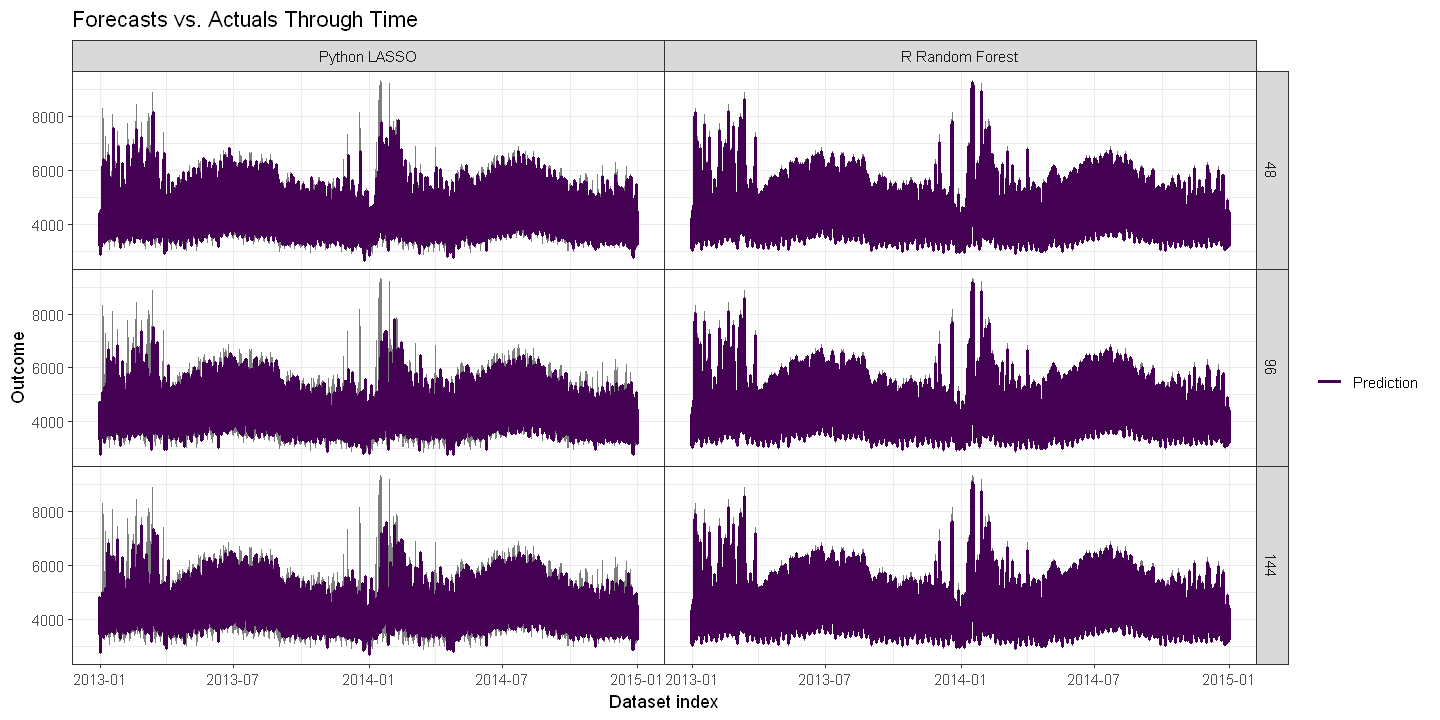

In [40]:
# Without filtering the data, this will take a few seconds to plot.
plot(data_historical)

#### `forecastML::plot()` historical fit for all 12AM demand for the 1-day-ahead horizon

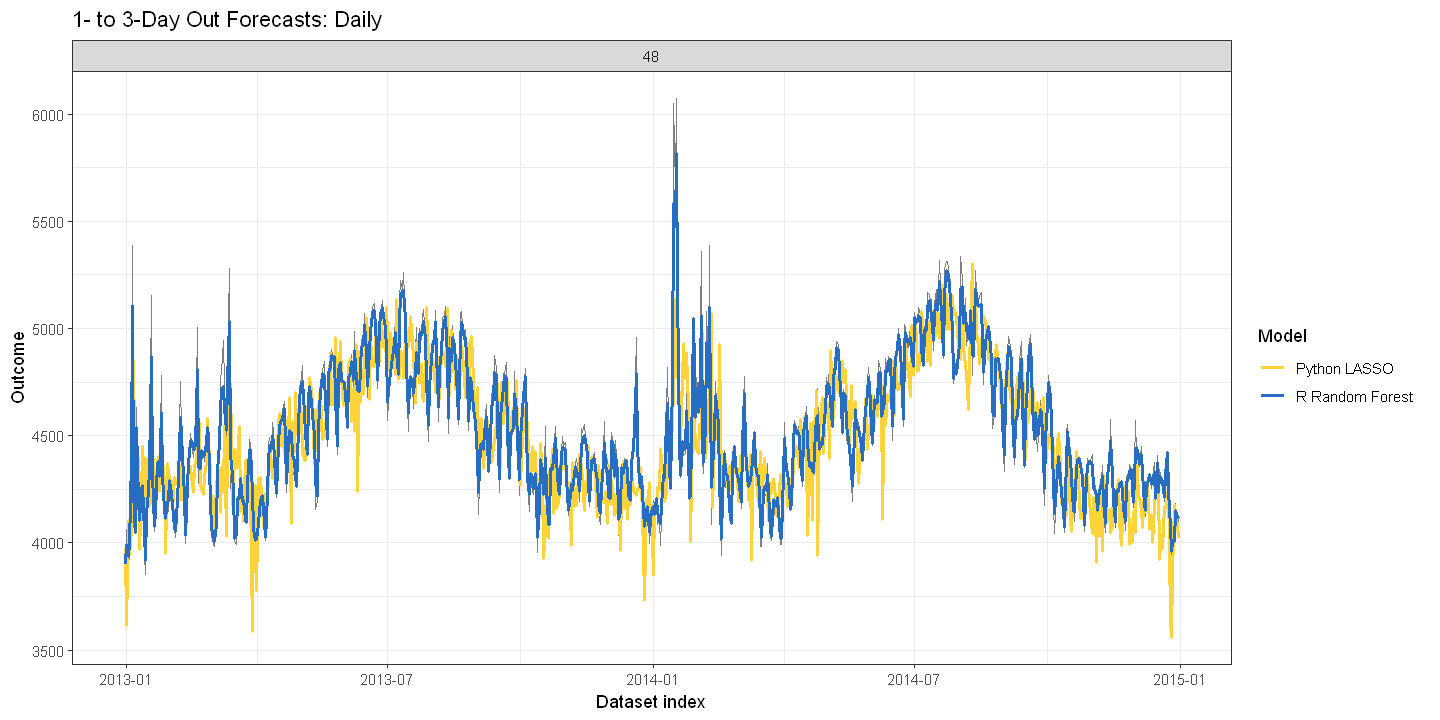

In [41]:
view_dates <- seq(as.POSIXct(min(dates), tz = "UTC"), 
                  as.POSIXct(max(dates), tz = "UTC"), 
                  by = "1 day")

plot(data_historical, facet = ~ horizon, horizons = 48, valid_indices = view_dates) + 
  ggtitle("1- to 3-Day Out Forecasts: Daily") + 
  scale_color_manual(values = c("Python LASSO" = "#ffd43b", "R Random Forest" = "#276DC2"))

### `forecastML::create_lagged_df(type = "forecast")`

In [42]:
data_forecast <- forecastML::create_lagged_df(data_all, type = "forecast", outcome_col = 1,
                                              lookback = lookback, horizon = horizons,
                                              dates = dates, frequency = frequency,
                                              dynamic_features = dynamic_features)

head(data_forecast$horizon_144)

,index,horizon,Demand_lag_144,Demand_lag_336,Demand_lag_17520,Temperature_lag_144,Temperature_lag_336,Temperature_lag_17520,Holiday,hour,weekday,month,year
,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>
1,2015-01-01 00:00:00,1,4183.850,4052.930,4198.399,19.6,16.4,18.1,NA,NA,NA,NA,NA
2,2015-01-01 00:30:00,2,3933.165,3820.782,3914.647,19.4,16.2,18.2,NA,NA,NA,NA,NA
3,2015-01-01 01:00:00,3,3733.846,3623.968,3672.550,19.0,16.1,17.9,NA,NA,NA,NA,NA
4,2015-01-01 01:30:00,4,3577.479,3470.303,3497.539,18.9,15.8,17.6,NA,NA,NA,NA,NA
5,2015-01-01 02:00:00,5,3432.463,3317.998,3339.145,18.5,15.1,16.8,NA,NA,NA,NA,NA
6,2015-01-01 02:30:00,6,3334.179,3202.149,3204.313,18.4,15.0,16.3,NA,NA,NA,NA,NA


### Fill in future dynamic features

* Filling in future `NA` values for non-lagged features is a bit of a manual process.
  
  
* The features can remain `NA` if the ML model can handle missing values.
  
  
* The feature types (e.g., factor) should match the training dataset to work with the trained ML model. Don't add new features here.

In [43]:
for (i in seq_along(horizons)) {
  
  data_forecast[[i]]$hour <- lubridate::hour(data_forecast[[i]]$index)
  data_forecast[[i]]$weekday <- factor(lubridate::wday(data_forecast[[i]]$index))  # Match the training data type.
  data_forecast[[i]]$month <- factor(lubridate::month(data_forecast[[i]]$index))  # Match the training data type.
  data_forecast[[i]]$year <- lubridate::year(data_forecast[[i]]$index)
  
  # New Year's Eve.
  data_forecast[[i]]$Holiday <- with(data_forecast[[i]], ifelse(lubridate::mday(data_forecast[[i]]$index) == 1, TRUE, FALSE))
}

### Forecast into the future with `forecastML::predict()`

In [44]:
data_forecasts_py <- predict(model_results_py_final,
                             prediction_function = list(r_wrapper_for_py_predict_fun), 
                             data = data_forecast)

data_forecasts_r <- predict(model_results_r_final,
                            prediction_function = list(r_predict_fun), 
                            data = data_forecast)

data_forecasts <- predict(model_results_py_final, model_results_r_final,
                          prediction_function = list(r_wrapper_for_py_predict_fun, r_predict_fun), 
                          data = data_forecast)

### `forecastML::plot()` direct-horizon-specific model forecasts

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



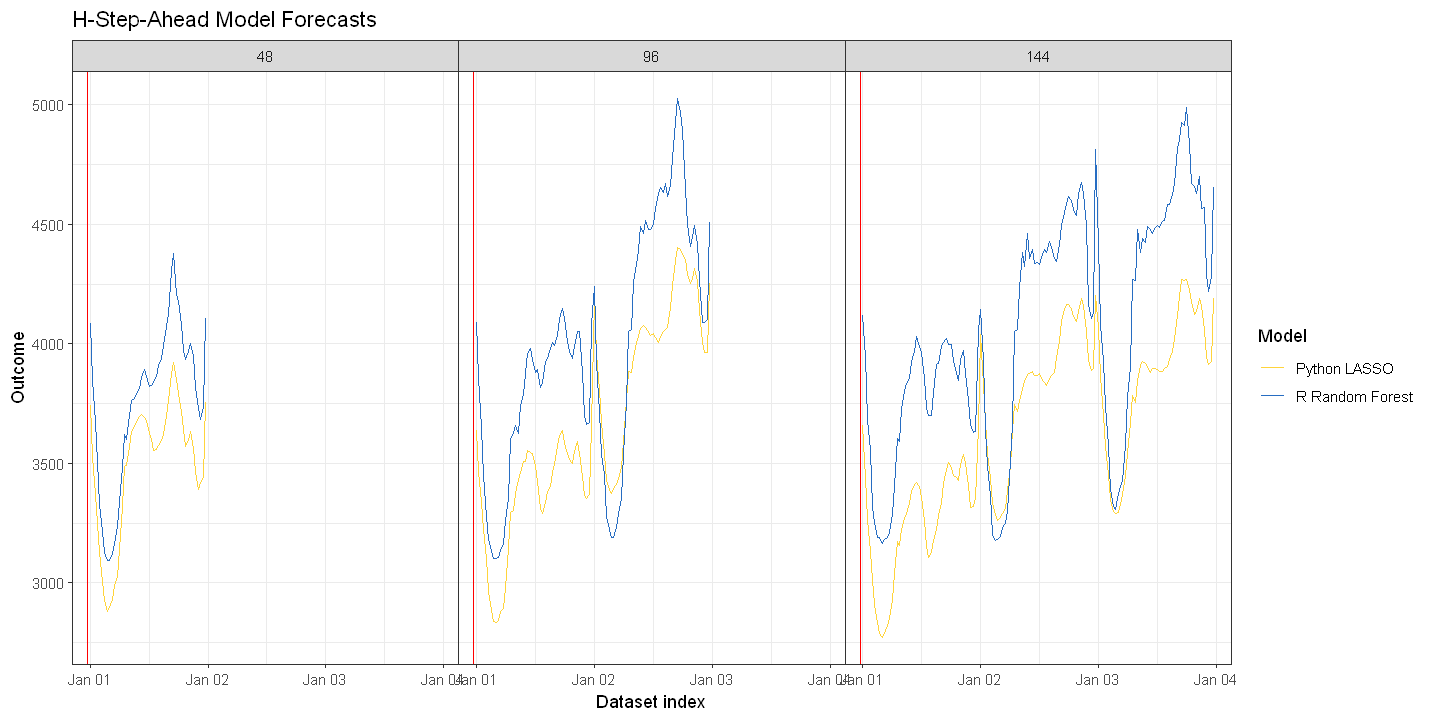

In [45]:
plot(data_forecasts, facet = ~ horizon) + 
  scale_color_manual(values = c("Python LASSO" = "#ffd43b", "R Random Forest" = "#276DC2"))

### `forecastML::combine_forecasts()`

* For each of `Python` and `R`, our 3 direct-horizon forecast models have been separately trained and are producing distinct forecasts at various horizons. The first ensemble is to combine the 3 direct-horizon forecasts into a single forecast. The second ensemble--which is optional--is to average different ML models in a cross-sectional way at each forecast step into the future.
  
  
* Below we'll create an ensemble of the `Python` LASSO and the `R` Random Forest models using the strategy outlined at the end of the [forecast combination vignette](https://nredell.github.io/forecastML/doc/combine_forecasts).

In [46]:
data_combined_py <- forecastML::combine_forecasts(data_forecasts_py)

data_combined_r <- forecastML::combine_forecasts(data_forecasts_r)

data_combined <- forecastML::combine_forecasts(data_forecasts, aggregate = stats::median)

#### `forecastML::plot()` the final ensemble forecast of `Python` and `R` models

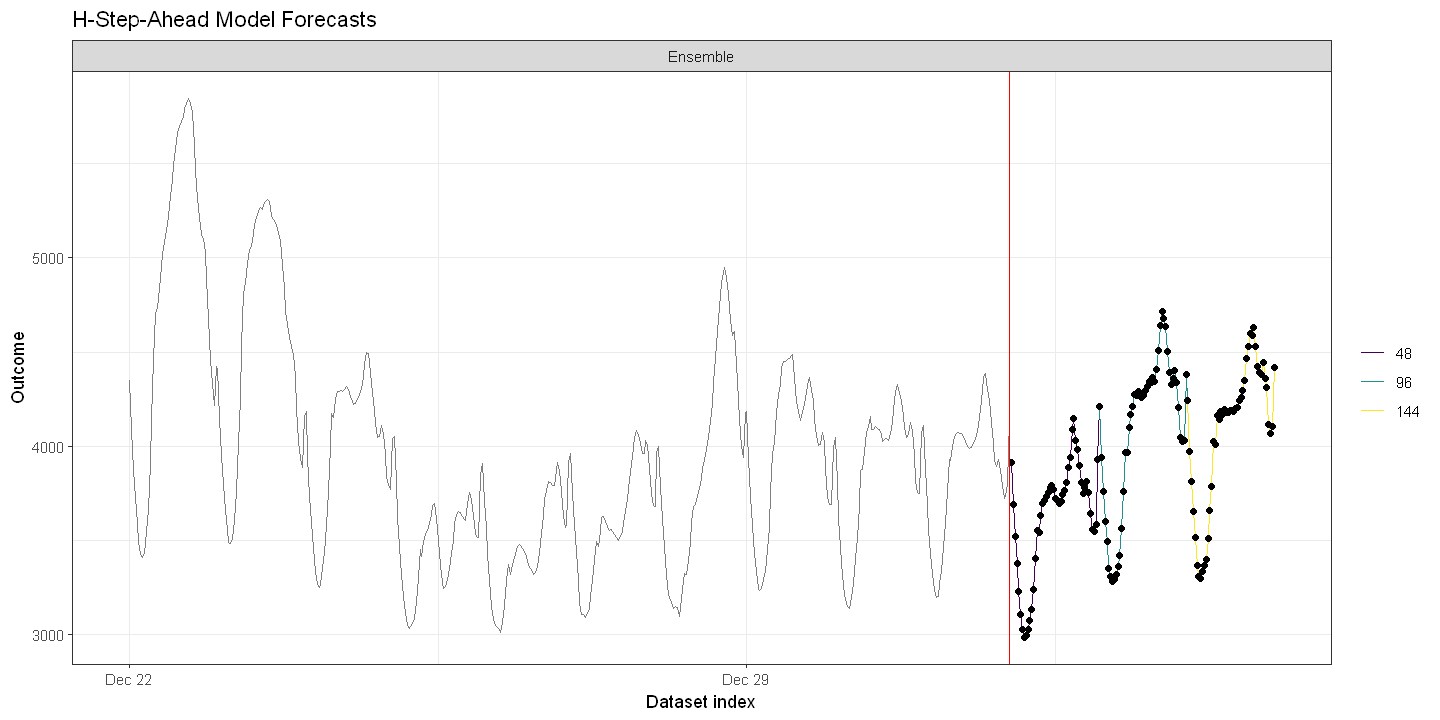

In [47]:
remove_dates <- -(1:(nrow(data) - records_per_day * 10))

data_actual <- data[remove_dates, ]

plot(data_combined, data_actual = data_actual, actual_indices = data_actual$Time)

#### Custom plot - Individual forecasts on 1 plot

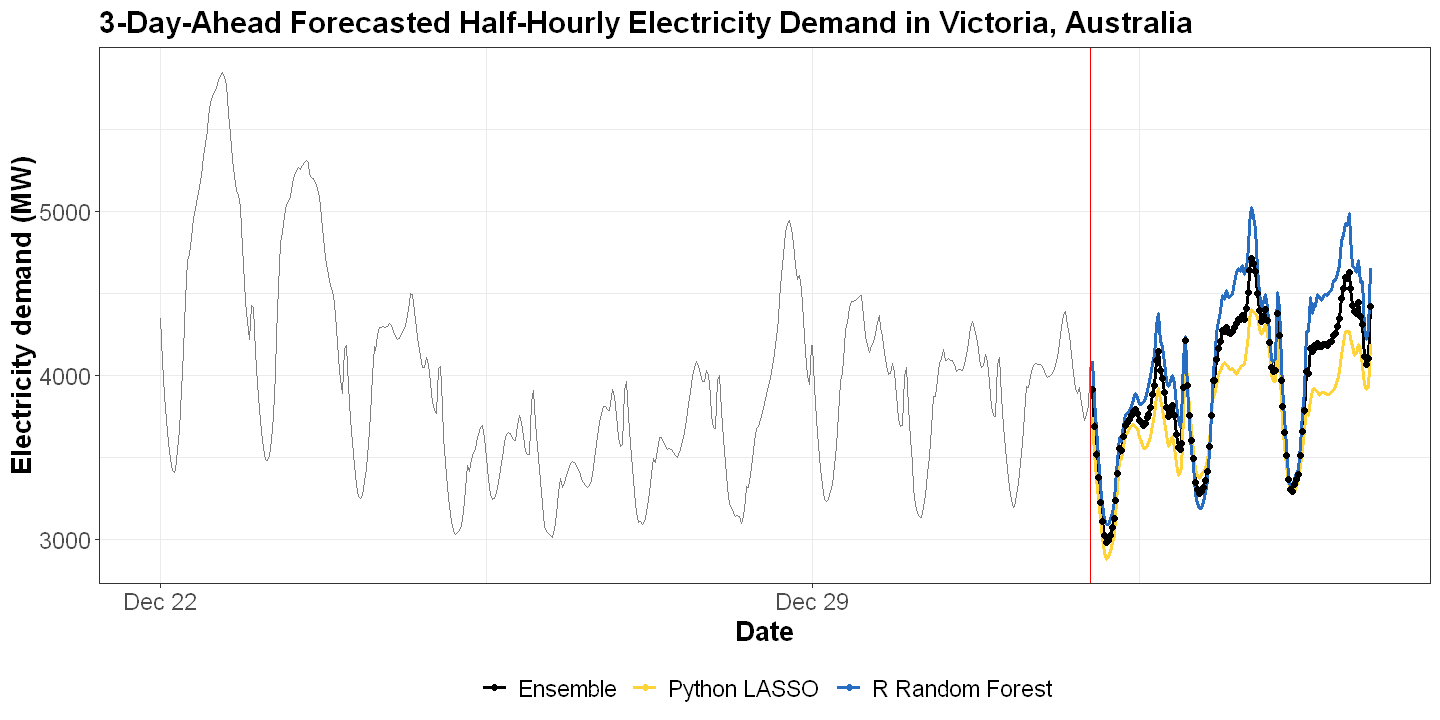

In [48]:
data_plot <- dplyr::bind_rows(data_combined, data_combined_py, data_combined_r)
data_plot_point <- data_plot[data_plot$model == "Ensemble", ]

p <- ggplot(data_plot, aes(x = forecast_period, y = Demand_pred, color = model))
p <- p + geom_line(size = 1.05)
p <- p + geom_point(data = data_plot_point, aes(x = forecast_period, y = Demand_pred, color = model))
p <- p + geom_line(data = data[remove_dates, ], aes(x = Time, y = Demand), color = "gray50")
p <- p + geom_vline(xintercept = max(data$Time), color = "red")
p <- p + scale_color_manual(values = c("Python LASSO" = "#ffd43b", "R Random Forest" = "#276DC2", "Ensemble" = "black"))
p <- p + theme_bw() + theme(
    plot.title = element_text(size = 18, face = "bold"),
    axis.title = element_text(size = 16, face = "bold"),
    axis.text = element_text(size = 14),
    legend.text = element_text(size = 14),
    legend.position = "bottom"
  )
p <- p + xlab("Date") + ylab("Electricity demand (MW)") + labs(color = NULL) + 
    ggtitle("3-Day-Ahead Forecasted Half-Hourly Electricity Demand in Victoria, Australia")
p

ggsave(file = "electricity_demand_final_plot.png", width = 7, height = 5)